In [42]:
import enum
import os
import copy
import math

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as log_progress
import matplotlib.pyplot as plt

# Parsing messages

In [3]:
class Message:
    def __init__(self, lines, filepath):
        assert(len(lines) == 4)
        assert(lines[0].startswith('Subject:'))
        
        subject = lines[0][8:].strip()
        self.text = [] if subject == '' else list(map(int, subject.split()))
        
        self.text += list(map(int, lines[2].split()))
        self.filename = os.path.basename(filepath)
        self.is_spam = filepath.find('spmsg') >= 0
            
            
    def __len__(self):
        return len(self.text)
        
        
    def __str__(self):
        return 'filename: {}, len: {}, is spam: {}'.format(self.filename, len(self.text), self.is_spam)
    
    
    def _repr_html_(self):
        return "<code>" + str(self) + "</code>"
    
    
    def n_grammate(self, n):
        return set(tuple(self.text[i:i+n]) for i in range(len(self.text) - n + 1))
        

In [4]:
def parse_message_file(filepath):
    lines = None
    with open(filepath, 'r') as f:
        lines = f.read().split('\n')
    return Message(lines, filepath)

In [5]:
def read_actual_ds():
    ds = []
    for num in range(1, 11):
        part = []
        prefix = 'messages/part{}'.format(num)
        for filename in os.listdir(prefix):
            filepath = os.path.join(prefix, filename)
            part.append(parse_message_file(filepath))
        ds.append(part)
    return ds

# Classificator

In [164]:
class SpamClassificator:
    Q_POWER = 2.0
    
    def __init__(self, train, lambdas, n, alpha):
        self.lambdas = lambdas
        self.n = n
        self.alpha = alpha
        
        self.class_count = {False: 0, True: 0}
        self.ngram_count = {False: {}, True: {}}
        self.all_ngrams = set()
        
        self.memoize = {}
        sum_ = 0
        
        for cluster in train:
            for message in cluster:
                self.class_count[message.is_spam] += 1
                
                n_grammated = message.n_grammate(n)
                sum_ += len(n_grammated)
                
                for ngram in n_grammated:
                    if ngram in self.ngram_count[message.is_spam]:
                        self.ngram_count[message.is_spam][ngram] += 1
                    else:
                        self.ngram_count[message.is_spam][ngram] = 1
                    self.all_ngrams.add(ngram)
        # print("Length summary of n_grams: ", sum_)
        
        self.initial = {
            is_spam: self.class_count[is_spam] / sum(self.class_count.values())
            for is_spam in [True, False]
        }
        
                        
                
    def get_ngram_probability(self, ngram, is_spam):
        if (ngram, is_spam) not in self.memoize:
            count = 0
            if ngram in self.ngram_count[is_spam]:
                count = self.ngram_count[is_spam][ngram]
            divisor = self.Q_POWER * self.alpha + self.class_count[is_spam]
            self.memoize[(ngram, is_spam)] = (count + self.alpha) / np.longdouble(divisor)
    
        return self.memoize[(ngram, is_spam)]
    
    
    def draw_table(self):
        print('Probability table ======')
        for is_spam in [True, False]:
            print('Spam  ' if is_spam else 'Legit ', end=':: ')
            for ngram in self.all_ngrams:
                print("{} : {}".format(ngram, self.get_ngram_probability(ngram, is_spam)), end=', ')
            print('')
        print('========================')

    
    def predict_log(self, test_message):
        n_grammated = test_message.n_grammate(self.n)
        
        score = {}
        cnt = 0
        for is_spam in [True, False]:
            score[is_spam] = np.log(self.initial[is_spam] * self.lambdas[is_spam])
                                        
            for ngram in n_grammated:
                if ngram in self.all_ngrams:
                    score[is_spam] += np.log(self.get_ngram_probability(ngram, is_spam))
                    cnt += 1
            
            for ngram in self.all_ngrams:
                if ngram not in n_grammated:
                    score[is_spam] += np.log(1.0 - self.get_ngram_probability(ngram, is_spam))
                    cnt += 1
                    
        total_log = sum(score.values())
        avg = -total_log / cnt
        
        for is_spam in [True, False]:
            score[is_spam] = np.exp(avg + score[is_spam])
        total = sum(score.values())
        
        # print(total)
        if total == 0:
            return {True: 0.0, False: 1.0}
        return {is_spam: s / total for is_spam, s in score.items()}
    
    def predict_stupid(self, test_message):
        n_grammated = test_message.n_grammate(self.n)
        
        score = {}
        cnt = 0
        for is_spam in [True, False]:
            score[is_spam] = self.initial[is_spam] * self.lambdas[is_spam]
                                        
            for ngram in n_grammated:
                if ngram in self.all_ngrams:
                    score[is_spam] *= self.get_ngram_probability(ngram, is_spam)
            
            for ngram in self.all_ngrams:
                if ngram not in n_grammated:
                    score[is_spam] *= 1.0 - self.get_ngram_probability(ngram, is_spam)
                    
        total = sum(score.values())
        if total == 0:
            return {True: 0.0, False: 1.0}
        return {is_spam: s / total for is_spam, s in score.items()}

# Some hand-managed testing

In [63]:
# tested via cpp code from codeforces just to be sure everything is ok
test_ds = []
prefix = 'test'
for filename in os.listdir(prefix):
    filepath = os.path.join(prefix, filename)
    test_ds.append(parse_message_file(filepath))
test_ds = [test_ds]

test_classificator = SpamClassificator(test_ds, {False: 1.0, True: 1.0}, 1, 1.0)
test_classificator.draw_table()

test_messages = [
    Message(['Subject:', '', '1 3 1', ''], 'testing.txt'),
    Message(['Subject: 3 4', '', '2 5 6', ''], 'testing2.txt')
]

for test_message in test_messages:
    print(test_classificator.predict_stupid(test_message))

Probability table ======
Spam  :: (2,) : 0.6, (5,) : 0.2, (4,) : 0.4, (1,) : 0.8, (3,) : 0.4, 
Legit :: (2,) : 0.25, (5,) : 0.5, (4,) : 0.75, (1,) : 0.25, (3,) : 0.25, 
{True: 0.94022227748340569904, False: 0.05977772251659430097}
{True: 0.24680645938780427301, False: 0.75319354061219572703}


# Drawing ROC-curve

In [214]:
def draw(predictions):
    dots = []
    for w in [x[0] for x in sorted(predictions, key=lambda x: x[0])]:
        tp = 0
        fp = 0
        neg = 0
        pos = 0
        for (pred, expect) in predictions:
            if pred > w:
                if expect:
                    tp += 1
                else:
                    fp += 1
            if not expect:
                neg += 1
            else:
                pos += 1
        fpr = fp / neg
        tpr = tp / pos
        dots.append((fpr, tpr))
    dots = sorted(dots)
    
    plt.figure(figsize=(7, 7))
    x, y = ([x for (x, _) in dots], [y for (_, y) in dots])
    plt.plot(x, y)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

# Cross-validation k-fold count

In [33]:
alphas = {
    1: [0.1, 0.01, 0.005, 0.001, 0.0007, 0.0001, 0.00001],
    2: [0.1, 0.01, 0.005],
    3: [0.1, 0.01]
}

params = []
for n in range(1, 4):
    for alpha in alphas[n]:
        params.append((n, alpha))
ds = read_actual_ds()

In [34]:
total = sum([len(x) for x in ds])
for (n, alpha) in log_progress(params):
    if (n, alpha) in results:
        print(n, alpha, results[(n, alpha)])
        continue
    true = 0
    for num in range(10):
        train = copy.deepcopy(ds)
        test = train.pop(num)
        
        classificator = SpamClassificator(train, {False: 1e100, True: 1e100}, n, alpha)
        
        for test_message in test:
            prediction = classificator.predict_stupid(test_message)
            
            result = max(prediction, key=prediction.get)
            target = test_message.is_spam
            if result == target:
                true += 1
                
    accuracy = true / total
    results[(n, alpha)] = accuracy
    print(n, alpha, accuracy)

1 0.1 0.9532110091743119
1 0.01 0.9587155963302753
1 0.005 0.9577981651376147
1 0.001 0.9605504587155963
1 0.0007 0.963302752293578
1 0.0001 0.9660550458715597
1 1e-05 0.9678899082568807
2 0.1 0.8990825688073395
2 0.01 0.9311926605504587
2 0.005 0.936697247706422
3 0.1 0.8412844036697248
3 0.01 0.8825688073394495



# First let's try some "bad" case

In [161]:
def predict_n_draw(n, alpha, lambdas):
    predictions = []
    for num in log_progress(list(range(10))):
        train = copy.deepcopy(ds)
        test = train.pop(num)

        classificator = SpamClassificator(train, lambdas, n, alpha)

        for test_message in test:
            prediction = classificator.predict_stupid(test_message)

            predictions.append((prediction[True], test_message.is_spam))
    draw(predictions)

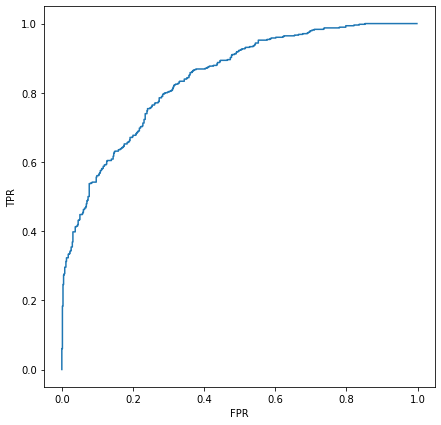

In [215]:
predict_n_draw(1, 100, {False: 1e-100, True: 1e-100})

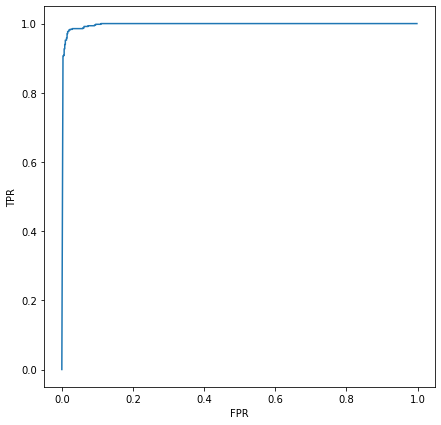

In [216]:
predict_n_draw(1, 1e-5, {False: 1e100, True: 1e100})

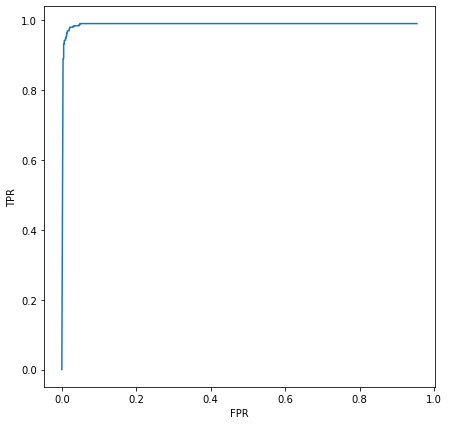

In [217]:
predict_n_draw(2, 1e-5, {False: 1e100, True: 1e100})

# Ok, let's find appropriate lambda

In [191]:
class LambdaIncreaseException(Exception):
    pass


def count_true(n, alpha, lambdas, raising):
    true = 0
    erroring = False
    for num in log_progress(list(range(10))):
        train = copy.deepcopy(ds)
        test = train.pop(num)
        
        classificator = SpamClassificator(train, lambdas, n, alpha)
        
        for test_message in test:
            prediction = classificator.predict_stupid(test_message)
            
            result = max(prediction, key=prediction.get)
            target = test_message.is_spam
            
            if result == target:
                true += 1
            if not target and result:
                if raising:
                    raise LambdaIncreaseException
                else:
                    erroring = True
    return true, erroring

    

def find_lambda_range(n, alpha, lambdas):
    true = 0
    prev_lambdas = lambdas
    while True:
        try:
            count_true(n, alpha, lambdas, True)
            break
        except LambdaIncreaseException:
            prev_lambdas = copy.copy(lambdas)
            lambdas[False] *= 1e10
            continue

    return (prev_lambdas[0], lambdas[0])

In [202]:
start_lambda, end_lambda = find_lambda_range(1, 1e-5, {False: 1e100, True: 1e100})

In [204]:
dots = []
for i in range(10): # i think it's enough
    print(start_lambda, end_lambda)
    middle_lambda = (start_lambda + end_lambda) / 2
    
    true, erroring = count_true(1, 1e-5, {False: middle_lambda, True: 1e100}, False)
    if not erroring:
        end_lambda = middle_lambda
    else:
        dots.append((middle_lambda, true / total))
        start_lambda = middle_lambda
end_lambda

9.999999999999999e+129 9.999999999999998e+139



9.999999999999999e+129 5.0000000005e+139



9.999999999999999e+129 2.50000000075e+139



1.250000000875e+139 2.50000000075e+139



1.8750000008125e+139 2.50000000075e+139



1.8750000008125e+139 2.18750000078125e+139



1.8750000008125e+139 2.031250000796875e+139



1.8750000008125e+139 1.9531250008046874e+139



1.8750000008125e+139 1.9140625008085937e+139



1.8750000008125e+139 1.894531250810547e+139


1.8847656258115234e+139

In [210]:
for lambda_ in np.linspace(1e100, end_lambda, 30):
    true = 0
    stop = False
    
    true, erroring = count_true(1, 1e-5, {False: lambda_, True: 1e100}, False)
    
    accuracy = true / total
    dots.append((lambda_, accuracy))
    
    if not erroring:
        break
print(dots)


[(1.250000000875e+139, 0.8605504587155963), (1.8750000008125e+139, 0.8605504587155963), (1e+100, 0.9678899082568807), (6.4991918131431845e+137, 0.8688073394495412), (1.2998383626286369e+138, 0.8669724770642202), (1.9497575439429554e+138, 0.8660550458715597), (2.5996767252572738e+138, 0.8660550458715597), (3.2495959065715926e+138, 0.8660550458715597), (3.899515087885911e+138, 0.865137614678899), (4.549434269200229e+138, 0.8642201834862385), (5.1993534505145476e+138, 0.8642201834862385), (5.8492726318288664e+138, 0.8642201834862385), (6.499191813143185e+138, 0.863302752293578), (7.149110994457503e+138, 0.863302752293578), (7.799030175771821e+138, 0.863302752293578), (8.44894935708614e+138, 0.8623853211009175), (9.098868538400458e+138, 0.8614678899082568), (9.748787719714776e+138, 0.8614678899082568), (1.0398706901029095e+139, 0.8614678899082568), (1.1048626082343414e+139, 0.8614678899082568), (1.1698545263657733e+139, 0.8605504587155963), (1.2348464444972052e+139, 0.8605504587155963), (

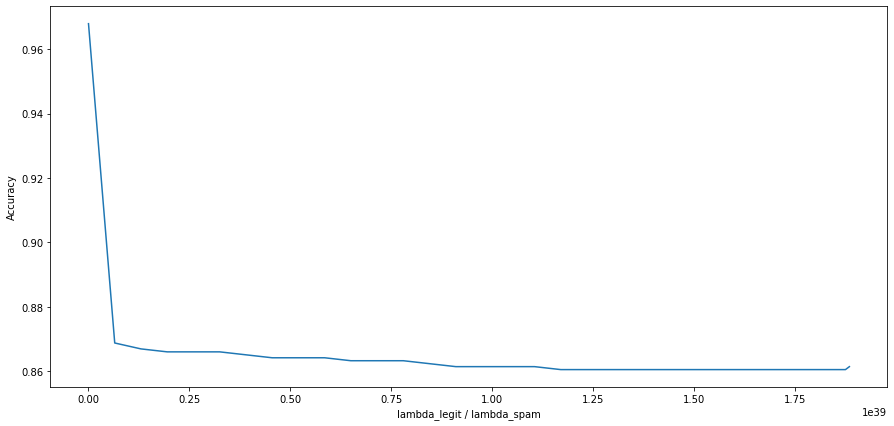

In [230]:
dots = sorted(dots)
plt.figure(figsize=(15,7))
x, y = ([x / 1e100 for (x, _) in dots], [y for (_, y) in dots])
plt.plot(x, y)
plt.xlabel("lambda_legit / lambda_spam")
plt.ylabel("Accuracy")
plt.show()

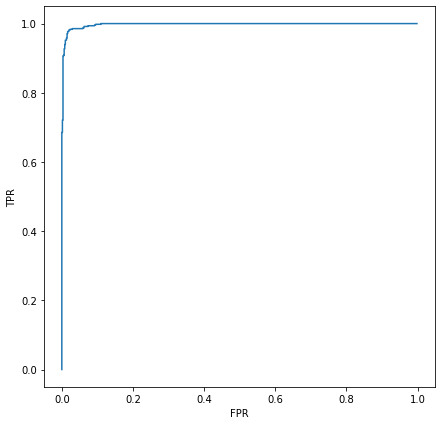

In [218]:
predict_n_draw(1, 1e-5, {False: end_lambda, True: 1e100})

In [231]:
dots[-1]

(1.8847656258115234e+139, 0.8614678899082568)